# Exploratory analysis of combined dataset

In [112]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [3]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [269]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final.pkl')

# drop CET datetime column; no longer needed
df.drop(columns=['datetime_cet'], inplace=True)
# move label/target to the end of the dataframe
rearranged_columns = [col for col in df.columns if col != 'actual_generated_smard_mwh'] + ['actual_generated_smard_mwh']
df = df[rearranged_columns]
# split SMARD forecasted feature since I don't want to use this in model training; then drop from df
smard_forecasted_generation_series = df['forecasted_generation_smard_mwh']
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hour                                            48168 non-null  int32  
 1   day_of_week                                     48168 non-null  int32  
 2   day_of_month                                    48168 non-null  int32  
 3   month_number                                    48168 non-null  int32  
 4   year                                            48168 non-null  int32  
 5   meteorological_season                           48168 non-null  object 
 6   turbines_in_operation                           48168 non-null  int64  
 7   total_nominal_capacity_operational_turbines_mw  48168 non-null  float64
 8   day_ahead_price_eur_mwh                         41618 non-null  float

In [270]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_wind_gusts_10m',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m'
]

unweighted_wx_features = [
    'temp_2m_celsius',
    'wind_gusts_10m',
    'mean_sea_level_pressure_mb',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

In [271]:
df.isna().sum()

hour                                                 0
day_of_week                                          0
day_of_month                                         0
month_number                                         0
year                                                 0
meteorological_season                                0
turbines_in_operation                                0
total_nominal_capacity_operational_turbines_mw       0
day_ahead_price_eur_mwh                           6550
total_nominal_capacity_smard_mw                      0
total_net_load_smard_mwh                             0
residual_load_smard_mwh                              0
mean_wind_speed_10m                                  0
mean_wind_speed_100m                                 0
wind_direction_angle_10m                             0
wind_direction_angle_100m                            0
mean_sea_level_pressure_mb                           0
wind_gusts_10m                                       0
temp_2m_ce

In [63]:
df.describe()

,hour,day_of_week,day_of_month,month_number,year,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,actual_generated_smard_mwh,day_ahead_price_eur_mwh,total_nominal_capacity_smard_mw,forecasted_generation_smard_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,mean_sea_level_pressure_mb,wind_gusts_10m,temp_2m_celsius,weighted_temp_2m_celsius,weighted_wind_gusts_10m,weighted_mean_sea_level_pressure_mb,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,public_holiday
count,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,41618.000000,48168.000000,48144.00000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000
mean,11.500000,2.997509,15.716492,6.251619,2020.270553,28625.879422,54216.183891,11193.426461,97.951645,53849.704638,11099.65571,56219.703579,36924.776340,3.403946,5.747104,191.878098,194.632889,1016.364811,6.945310,10.216761,10.357187,7.247443,1015.912618,3.642511,6.125059,195.617986,198.109288,0.002429
std,6.922258,1.999396,8.793736,3.439449,1.599109,462.136710,2355.850195,8992.759097,107.700848,1700.822139,8848.40467,9832.762332,12559.928192,1.373546,2.210253,64.455742,65.061592,9.026248,2.917239,7.485719,7.343503,3.079814,9.431296,1.496988,2.373912,67.100808,67.589109,0.049225
min,0.000000,0.000000,1.000000,1.000000,2018.000000,27464.000000,49732.097897,100.250000,-129.960000,51633.000000,161.25000,30909.000000,-5370.500000,0.819818,1.150553,22.478209,21.372946,972.342813,1.910964,-12.340430,-12.353219,1.816411,971.750173,0.860357,1.186652,18.788045,19.789689,0.000000
25%,5.750000,1.000000,8.000000,3.000000,2019.000000,28304.000000,52353.193417,4245.875000,35.050000,52792.000000,4313.50000,48175.687500,28525.562500,2.391495,4.161518,146.448418,148.723846,1011.134180,4.782694,4.303812,4.642113,4.962623,1010.345478,2.527088,4.397004,147.137573,148.870189,0.000000
50%,11.500000,3.000000,16.000000,6.000000,2020.000000,28664.000000,53790.932467,8473.000000,53.920000,53184.000000,8413.62500,56035.250000,37295.125000,3.090817,5.346018,200.376053,204.613251,1016.906797,6.369528,9.597971,9.776790,6.645048,1016.555933,3.320524,5.722192,207.578807,211.532572,0.000000
75%,17.250000,5.000000,23.000000,9.000000,2022.000000,28982.000000,56033.684347,15918.500000,119.802500,55289.000000,15543.68750,64212.000000,45628.437500,4.094744,6.930403,242.063076,245.364609,1022.105957,8.502666,15.746774,15.714599,8.909549,1022.037480,4.424359,7.448320,247.089817,249.770198,0.000000
max,23.000000,6.000000,31.000000,12.000000,2023.000000,29418.000000,59315.041337,45285.250000,871.000000,57590.000000,43017.75000,81077.500000,74313.250000,11.017428,17.585875,335.886993,338.821259,1041.468125,23.699093,33.672296,33.866775,25.159453,1041.719498,12.178314,19.184025,339.868895,341.861569,1.000000


-----

### Just had an idea: Add German public holidays data to dataset as an additional feature/predictor!

#### Fetch German public holiday dates from free API service (thanks, guys! 👍🏻)
- Link: https://feiertage-api.de
- 117 public holidays during my chosen time period

In [7]:
# years = [2018, 2019, 2020, 2021, 2022, 2023]
# list_of_datadicts = []

# for year in years:
#     url_endpoint = f'https://feiertage-api.de/api/?jahr={year}&nur_daten'
#     response = requests.get(url_endpoint)

#     if response.status_code == 200:  
#             # Decode JSON response object to Python dict
#             list_of_datadicts.append(response.json())
#     else:
#         print(f'Request failed with status code: {response.status_code}')
        
# len(list_of_datadicts)

6

In [29]:
# df_public_holidays = pd.DataFrame(list_of_datadicts)

# # Map all dates to datetime timestamps localise to UTC (since only day alignment is needed, not hourly)
# df_public_holidays = df_public_holidays.map(lambda date: pd.to_datetime(date, yearfirst=True, utc=True))

# # Flatten the dataframe to 1D array of Timestamps!
# public_holiday_timestamps = df_public_holidays.to_numpy().flatten()

# # Creat new column by putting bool array as condition inside np.where and replacing bool with 0s & 1s
# df['public_holiday'] = np.where(df.index.isin(public_holiday_timestamps), 1, 0)

In [37]:
# df['public_holiday'].sum()

117

#### Save to pickle

In [38]:
# df.to_pickle(data_push_path / 'df_main_smard_era5_final.pkl')

-----

-----

## Check for linear correlations between features and label

In [304]:
def plot_correlation_heatmap(df):
    # Get the correlation matrix as a dataframe
    corr = df.corr(numeric_only=True)

    # Create mask to remove redundant half
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Abbreviate column names; select only numeric columns in df!
    abbreviated_column_names = [col[:40] + '...' if len(col) > 40 else col for col in df.select_dtypes('number').columns]
    
    # A couple of divergent colour palettes to see what works best
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={'shrink': .2}, annot=True, fmt='.2f', annot_kws={'size': 6},
                xticklabels=abbreviated_column_names, yticklabels=abbreviated_column_names)
    
    # Rotate x labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', fontsize=7)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

    # plt.tight_layout()
    plt.show()

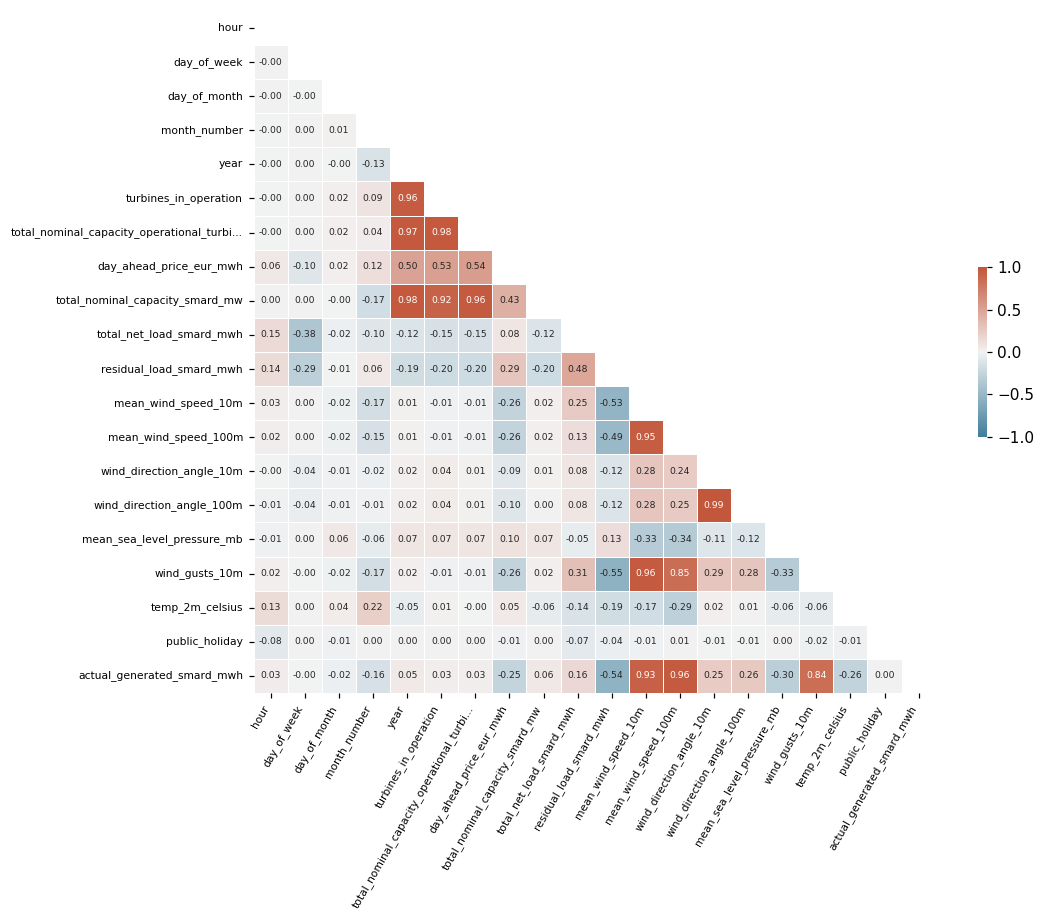

In [305]:
plot_correlation_heatmap(df_unweighted)

#### Stronger linear correlations between label and weighted wind features!
- Especially 100m wind, 10m gusts, and msl

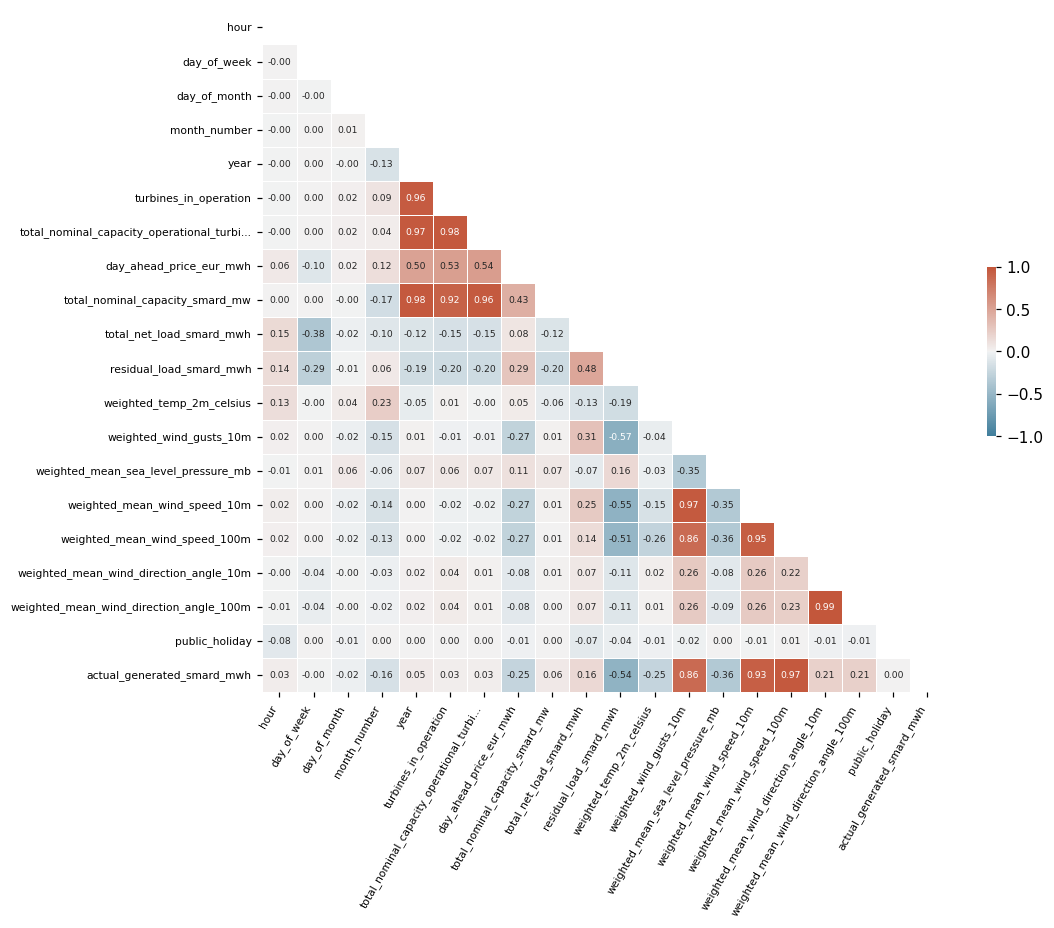

In [306]:
plot_correlation_heatmap(df_weighted)

----

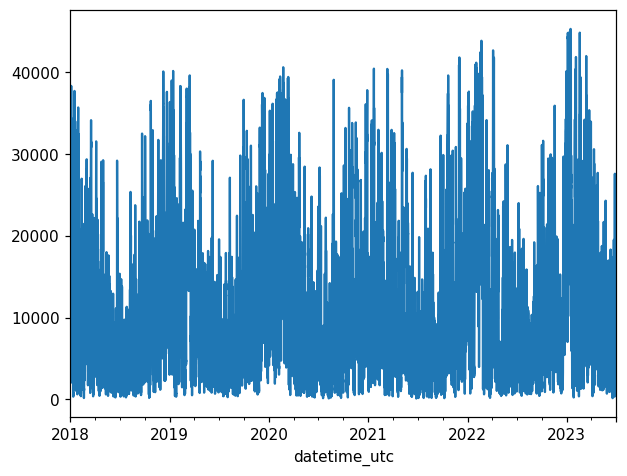

In [69]:
df['actual_generated_smard_mwh'].plot();

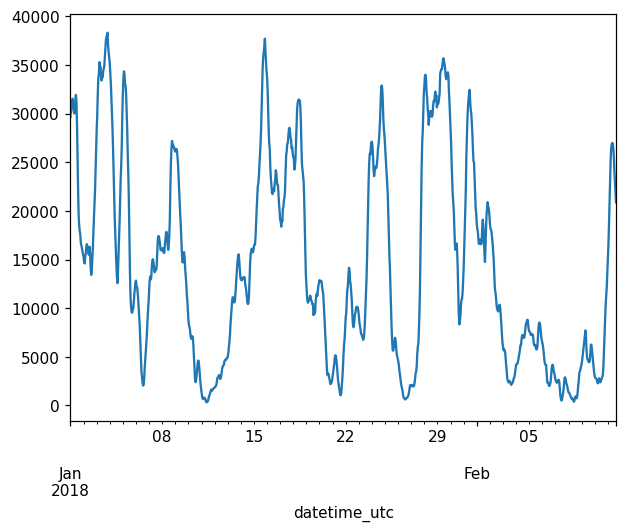

In [68]:
df['actual_generated_smard_mwh'].iloc[0:1_000].plot();

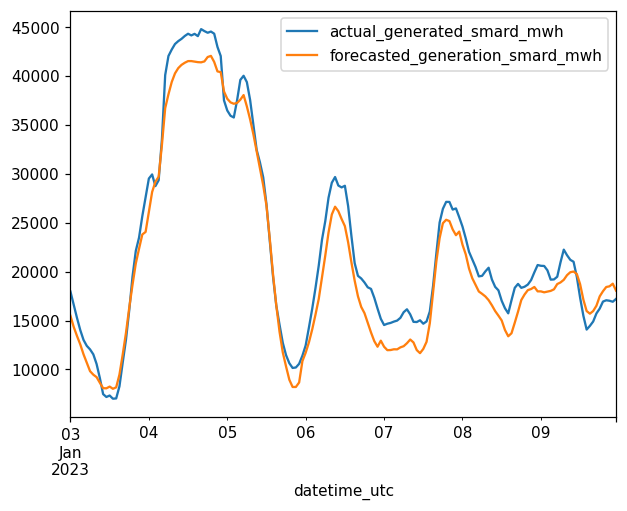

In [113]:
# SMARD actual vs SMARD forecasted
df.loc['2023-01-03': '2023-01-09'].plot(kind='line', y=['actual_generated_smard_mwh', 'forecasted_generation_smard_mwh']);

In [81]:
# filter on just one day
# df.loc['2023-01-01']

-----

### Plot a seasonal decomposition plot
- Use statsmodels' `seasonal_decompose`
    - https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

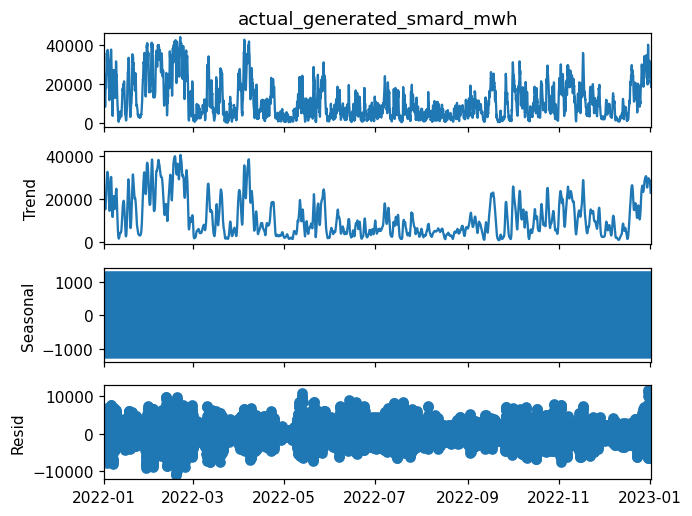

In [110]:
decomposed_result = seasonal_decompose(df.loc['2022-01-01':'2023-01-01', 'actual_generated_smard_mwh'], model='additive')
decomposed_result.plot()
plt.show()